## Distance of trans-eQTLs from the human TFs

 - How far are the trans-eQTLs from known transcription factors?
 - How does it compare to some randomly selected SNPs from the data?
 
To Do: Extend the analysis to multiple tissues

In [68]:
resdir = "/scratch/sbanerj/trans-eqtl/dev-pipeline/gtex_v8"
tissuelist = ["as", "sse"]
tejaas_preproc = "raw_std"
tejaas_method_variant = "permnull_sb0.1_knn"
rrfile = "rr.txt"
chrmlist = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
#chrmlist = [x for x in range(3, 23)]
tffile = "../external/human_TF_annotation_gencode_v26.txt"
Nrand = 50000

In [13]:
import numpy as np
import collections
import os
import time
import math

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib
import sys
sys.path.append('../')
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 24, colors = 'banskt', dpi = 72)

In [4]:
GENEINFO_FIELDS = ['name', 'ensembl_id', 'chrom', 'start', 'end']
class GeneInfo(collections.namedtuple('_GeneInfo', GENEINFO_FIELDS)):
    __slots__ = ()

tflist = list()
with open(tffile, 'r') as instream:
    next(instream)
    for line in instream:
        linesplit = line.strip().split()
        ensembl = linesplit[0]
        chrom = int(linesplit[1])
        start = int(linesplit[2])
        end = int(linesplit[3])
        name = linesplit[4]
        tflist.append(GeneInfo(name = name, ensembl_id = ensembl, chrom = chrom, start = start, end = end))

In [14]:
def find_minimum_distance(spos, starts, ends):
    diffs = zip([spos - x for x in starts], [spos - x for x in ends])
    dists = np.array([math.copysign(min(abs(a), abs(b)), a) if a * b > 0 else 0 for a, b in diffs])
    return dists[np.argmin(np.abs(dists))]

def find_minimum_distance_from_start(spos, starts):
    dists = np.array([spos - x for x in starts])
    return dists[np.argmin(np.abs(dists))]

In [17]:
def read_tejaas(filename):
    rsidlist = list()
    bplist   = list()
    pvallist = list()
    with open(filename, 'r') as instream:
        next(instream)
        for line in instream:
            linesplit = line.strip().split()
            rsid = linesplit[0]
            bppos = int(linesplit[1])
            pval = float(linesplit[5])
            rsidlist.append(rsid)
            bplist.append(bppos)
            pvallist.append(pval)
    return rsidlist, pvallist, bplist

def read_tejaas_all_chrom(filefmt, chrmlist):
    gwrsids = list()
    gwpvals = list()
    gwnsnps = dict()
    gwbppos = dict()
    
    for chrm in chrmlist:
        filepath = filefmt.format(chrm)
        rsids, pvals, bplist = read_tejaas(filepath)
        gwrsids += rsids
        gwpvals += pvals
        gwnsnps[chrm] = len(rsids)
        gwbppos[chrm] = np.array(bplist)
        
    gwpvals = np.array(gwpvals)
    pmax  = np.max(gwpvals[np.where(gwpvals > 0)])
    nonzero_pvals = gwpvals.copy()
    nonzero_pvals[np.where(gwpvals == 0)] = pmax
    
    return gwrsids, gwnsnps, gwbppos, nonzero_pvals

#### Randomly selected SNPs

In [10]:
snpdir = '/scratch/sbanerj/trans-eqtl/input/gtex/genotype/all_samples/'
snppos = dict()
for chrm in range(1, 23):
    fname = os.path.join(snpdir, 'GTEx_v6_imput_info04_HWEp1E6_PASS_chr{:d}.annot'.format(chrm))
    with open (fname, 'r') as instream:
        first = next(instream).strip().split()[0]
        for line in instream:
            pass
        last = line.strip().split()[0]
    firstpos = int(first.split('_')[1])
    lastpos = int(last.split('_')[1])
    snppos[chrm] = list([firstpos, lastpos])

In [15]:
mindist = list()
ratios = np.random.rand(22)
ndraws = [int(x) for x in np.around(Nrand * ratios / np.sum(ratios))]
for i, N in enumerate(ndraws):
    chrm = i + 1
    start_time = time.time()
    firstpos = snppos[chrm][0]
    lastpos  = snppos[chrm][1]
    rands = firstpos + np.random.rand(N) * (lastpos - firstpos)
    selects = np.sort([int(x) for x in rands])
    #selects  = firstpos + np.sort(np.random.choice(lastpos - firstpos, N, replace = False))
    select_time = time.time()
    print ("Selecting {:d} SNPs from chromosome {:d}: {:g} seconds".format(N, chrm, select_time - start_time))
    tfchrmlist = [x for x in tflist if x.chrom == chrm]
    tfstarts = [x.start for x in tflist if x.chrom == chrm]
    tfends = [x.end for x in tflist if x.chrom == chrm]
    for spos in selects:
        xmin = find_minimum_distance(spos, tfstarts, tfends)
        #xmin = find_minimum_distance_from_start(spos, tfends)
        #if xmin == 0: print(chrm, spos)
        mindist.append(xmin / 1e6)
    dist_time = time.time()
    print ("Finding distances: {:g} seconds".format(dist_time - select_time))

Selecting 1342 SNPs from chromosome 1: 0.00146747 seconds
Finding distances: 0.506115 seconds
Selecting 2749 SNPs from chromosome 2: 0.00233722 seconds
Finding distances: 0.770852 seconds
Selecting 2951 SNPs from chromosome 3: 0.00309348 seconds
Finding distances: 0.582318 seconds
Selecting 4027 SNPs from chromosome 4: 0.00400591 seconds
Finding distances: 0.587867 seconds
Selecting 1800 SNPs from chromosome 5: 0.00200295 seconds
Finding distances: 0.257648 seconds
Selecting 2009 SNPs from chromosome 6: 0.00179696 seconds
Finding distances: 0.449687 seconds
Selecting 1613 SNPs from chromosome 7: 0.00160933 seconds
Finding distances: 0.434908 seconds
Selecting 2839 SNPs from chromosome 8: 0.00279403 seconds
Finding distances: 0.586942 seconds
Selecting 2112 SNPs from chromosome 9: 0.00224495 seconds
Finding distances: 0.400353 seconds
Selecting 3315 SNPs from chromosome 10: 0.00306892 seconds
Finding distances: 0.479284 seconds
Selecting 1131 SNPs from chromosome 11: 0.0011301 seconds
F

In [18]:
filefmt = f'{resdir}/{tissuelist[0]}/tejaas/{tejaas_preproc}/{tejaas_method_variant}/chr' + "{:d}" + f'/{rrfile}'
gwrsids, gwnsnps, gwbppos, gwpvals = read_tejaas_all_chrom(filefmt, chrmlist)
gwlog10pvals = -np.log10(gwpvals)

In [48]:
filefmt = f'{resdir}/{tissuelist[1]}/tejaas/{tejaas_preproc}/{tejaas_method_variant}/chr' + "{:d}" + f'/{rrfile}'
gwrsids2, gwnsnps2, gwbppos2, gwpvals2 = read_tejaas_all_chrom(filefmt, chrmlist)
gwlog10pvals2 = -np.log10(gwpvals2)

In [55]:
log10cutoff = -np.log10(5e-8)
nchoose = np.where(gwlog10pvals >= log10cutoff)[0]
nchoose2 = np.where(gwlog10pvals2 >= log10cutoff)[0]

In [44]:
transeqtls = [gwrsids[i] for i in nchoose]

min_tf_dist_transeqtls = list()
for teqtl in transeqtls:
    chrm = int(teqtl.split('_')[0][3:])
    spos = int(teqtl.split('_')[1])
    firstpos = snppos[chrm][0]
    lastpos  = snppos[chrm][1]
    tfchrmlist = [x for x in tflist if x.chrom == chrm]
    tfstarts = [x.start for x in tflist if x.chrom == chrm]
    tfends = [x.end for x in tflist if x.chrom == chrm]
    xmin = find_minimum_distance(spos, tfstarts, tfends)
    min_tf_dist_transeqtls.append(xmin / 1e6)

In [56]:
transeqtls2 = [gwrsids2[i] for i in nchoose2]

min_tf_dist_transeqtls2 = list()
for teqtl in transeqtls2:
    chrm = int(teqtl.split('_')[0][3:])
    spos = int(teqtl.split('_')[1])
    firstpos = snppos[chrm][0]
    lastpos  = snppos[chrm][1]
    tfchrmlist = [x for x in tflist if x.chrom == chrm]
    tfstarts = [x.start for x in tflist if x.chrom == chrm]
    tfends = [x.end for x in tflist if x.chrom == chrm]
    xmin = find_minimum_distance(spos, tfstarts, tfends)
    min_tf_dist_transeqtls2.append(xmin / 1e6)

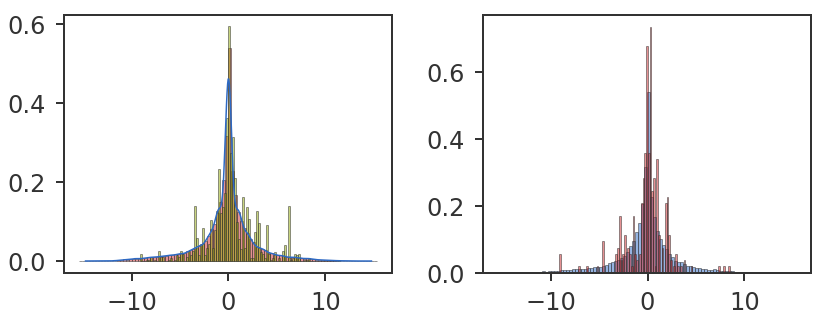

In [96]:
from scipy.interpolate import interp1d

fig = plt.figure(figsize = (12, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

xmax = np.around(np.max(mindist))
xmin = np.around(np.min(mindist))
bins = np.linspace(xmin, xmax, 60)
xbin = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
x = np.linspace(xbin[0], xbin[-1], 500)
yfreq, _ = np.histogram(mindist, bins = bins, density = True)
#yfreq = yhist / len(mindist)
fy = interp1d(xbin, yfreq, kind = 'cubic')
y = fy(x)
ax1.plot(x, y, alpha = 1)



ax1.hist(mindist, bins = 100, density = True, alpha = 0.5)
ax1.hist(min_tf_dist_transeqtls, bins = 100, density = True, alpha = 0.5)

ax2.hist(mindist, bins = 100, density = True, alpha = 0.5)
ax2.hist(min_tf_dist_transeqtls2, bins = 100, density = True, alpha = 0.5)

plt.tight_layout()
plt.show()

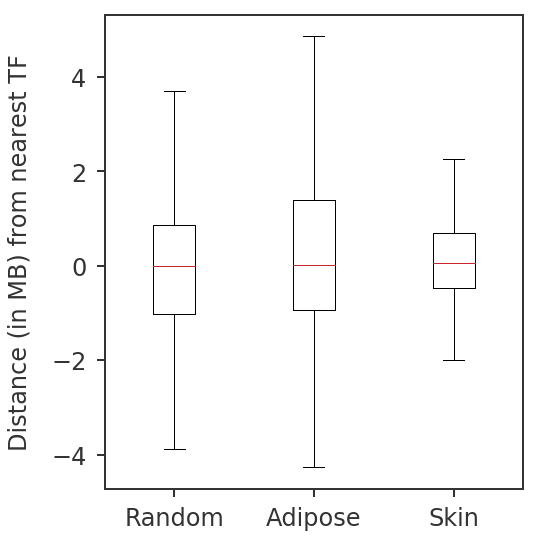

In [72]:
fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)

data = [mindist, min_tf_dist_transeqtls, min_tf_dist_transeqtls2]

ax1.boxplot(data, showfliers=False)
ax1.set_xticklabels(['Random', 'Adipose', 'Skin'])

ax1.set_ylabel('Distance (in MB) from nearest TF')
plt.tight_layout()
plt.show()

In [84]:
## Enrichment
len([x for x in mindist if abs(x) < 0.5]) / len(mindist)

0.3517740709628385

In [85]:
len([x for x in min_tf_dist_transeqtls if abs(x) < 0.5]) / len(min_tf_dist_transeqtls)

0.3512898330804249

In [86]:
len([x for x in min_tf_dist_transeqtls2 if abs(x) < 0.5]) / len(min_tf_dist_transeqtls2)

0.44370860927152317